# Calculating spectral indices

https://gisgeography.com/sentinel-2-bands-combinations/

https://github.com/awesome-spectral-indices/awesome-spectral-indices

![](https://media.springernature.com/lw685/springer-static/image/art%3A10.1038%2Fs41597-023-02096-0/MediaObjects/41597_2023_2096_Fig6_HTML.png)

In [1]:
import pyproj
import pystac_client
import stackstac
import xarray as xr
from shapely.geometry import box
from shapely.ops import transform

# STAC connection information for Sentinel 2 COGs
STAC_URL = "https://earth-search.aws.element84.com/v0"
STAC_COLLECTION = "sentinel-s2-l2a-cogs"

# a few more parameters
RESOLUTION = 20  # meters
BANDS = ["B04", "B03", "B02", "B08"]
START_DATE = "2022-09-01"
END_DATE = "2022-09-30"

In [2]:
import geopandas as gpd

In [5]:
df = gpd.read_file('../data/geo/sanguesa.geojson')

In [9]:
EPSG = df.crs.to_epsg()
EPSG

4326

In [10]:
AOI = df.geometry[0]

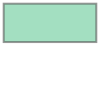

In [11]:
AOI

In [12]:
AOI.bounds

(-1.3284016753509604,
 42.557146942794816,
 -1.2395126017336509,
 42.59396630696821)

In [13]:
# STAC items store bounding box info in epsg:4326
transformer_5070 = pyproj.Transformer.from_crs(
    crs_from="epsg:4326",
    crs_to="epsg:5070",
    always_xy=True,
)

bbox_5070 = transform(transformer_5070.transform, AOI).bounds
bbox_5070

(6506768.743116945, 5713700.457603461, 6514163.340312216, 5722025.259819723)

In [14]:
catalog = pystac_client.Client.open(STAC_URL)

stac_items = catalog.search(
    collections=[STAC_COLLECTION],
    bbox=AOI.bounds,
    datetime=[START_DATE, END_DATE],
).get_all_items()

In [15]:
stac_items

In [16]:
len(stac_items)

11

In [17]:
sentinel_stack = stackstac.stack(
    items=stac_items,
    assets=BANDS,
    epsg=5070,
    resolution=RESOLUTION,
    bounds=bbox_5070,
    xy_coords="center",
)
sentinel_stack

/home/alabarga/BSC/code/environments/siglibre/lib/python3.10/site-packages/stackstac/prepare.py:363: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


<xarray.DataArray 'stackstac-8c3b5b0a7ca467e7df19ce7763538f96' (time: 11,
                                                                band: 4,
                                                                y: 417, x: 371)>
dask.array<fetch_raster_window, shape=(11, 4, 417, 371), dtype=float64, chunksize=(1, 1, 417, 371), chunktype=numpy.ndarray>
Coordinates: (12/30)
  * time                          (time) datetime64[ns] 2022-09-02T10:59:20 ....
    id                            (time) <U24 'S2B_30TXN_20220902_0_L2A' ... ...
  * band                          (band) <U3 'B04' 'B03' 'B02' 'B08'
  * x                             (x) float64 6.507e+06 6.507e+06 ... 6.514e+06
  * y                             (y) float64 5.722e+06 5.722e+06 ... 5.714e+06
    sentinel:sequence             <U1 '0'
    ...                            ...
    title                         (band) <U14 'Band 4 (red)' ... 'Band 8 (nir)'
    proj:transform                object {0, 4800000, 600000, 1, 10, -10}
    common_name                   (band) <U5 'red' 'green' 'blue' 'nir'
    center_wavelength             (band) float64 0.6645 0.56 0.4966 0.8351
    full_width_half_max           (band) float64 0.038 0.045 0.098 0.145
    epsg                          int64 5070
Attributes:
    spec:        RasterSpec(epsg=5070, bounds=(6506760, 5713700, 6514180, 572...
    crs:         epsg:5070
    transform:   | 20.00, 0.00, 6506760.00|\n| 0.00,-20.00, 5722040.00|\n| 0....
    resolution:  20

In [18]:
def flatten(x, dim="time"):
    assert isinstance(x, xr.DataArray)
    if len(x[dim].values) > len(set(x[dim].values)):
        x = x.groupby(dim).map(stackstac.mosaic)

    return x


# round time coordinates so all observations from the same day so they have
# equivalent timestamps
sentinel_stack = sentinel_stack.assign_coords(
    time=sentinel_stack.time.astype("datetime64[D]")
)

# mosaic along time dimension
flat_stack = flatten(sentinel_stack, dim="time")
flat_stack

/tmp/ipykernel_66551/1844268677.py:12: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  time=sentinel_stack.time.astype("datetime64[D]")


<xarray.DataArray 'stackstac-8c3b5b0a7ca467e7df19ce7763538f96' (time: 11,
                                                                band: 4,
                                                                y: 417, x: 371)>
dask.array<fetch_raster_window, shape=(11, 4, 417, 371), dtype=float64, chunksize=(1, 1, 417, 371), chunktype=numpy.ndarray>
Coordinates: (12/30)
  * time                          (time) datetime64[ns] 2022-09-02 ... 2022-0...
    id                            (time) <U24 'S2B_30TXN_20220902_0_L2A' ... ...
  * band                          (band) <U3 'B04' 'B03' 'B02' 'B08'
  * x                             (x) float64 6.507e+06 6.507e+06 ... 6.514e+06
  * y                             (y) float64 5.722e+06 5.722e+06 ... 5.714e+06
    sentinel:sequence             <U1 '0'
    ...                            ...
    title                         (band) <U14 'Band 4 (red)' ... 'Band 8 (nir)'
    proj:transform                object {0, 4800000, 600000, 1, 10, -10}
    common_name                   (band) <U5 'red' 'green' 'blue' 'nir'
    center_wavelength             (band) float64 0.6645 0.56 0.4966 0.8351
    full_width_half_max           (band) float64 0.038 0.045 0.098 0.145
    epsg                          int64 5070
Attributes:
    spec:        RasterSpec(epsg=5070, bounds=(6506760, 5713700, 6514180, 572...
    crs:         epsg:5070
    transform:   | 20.00, 0.00, 6506760.00|\n| 0.00,-20.00, 5722040.00|\n| 0....
    resolution:  20

In [19]:
%%time 
flat_stack = flat_stack.compute()

CPU times: user 3.75 s, sys: 902 ms, total: 4.65 s
Wall time: 50.6 s


In [20]:
len(flat_stack)

11

/home/alabarga/BSC/code/environments/siglibre/lib/python3.10/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


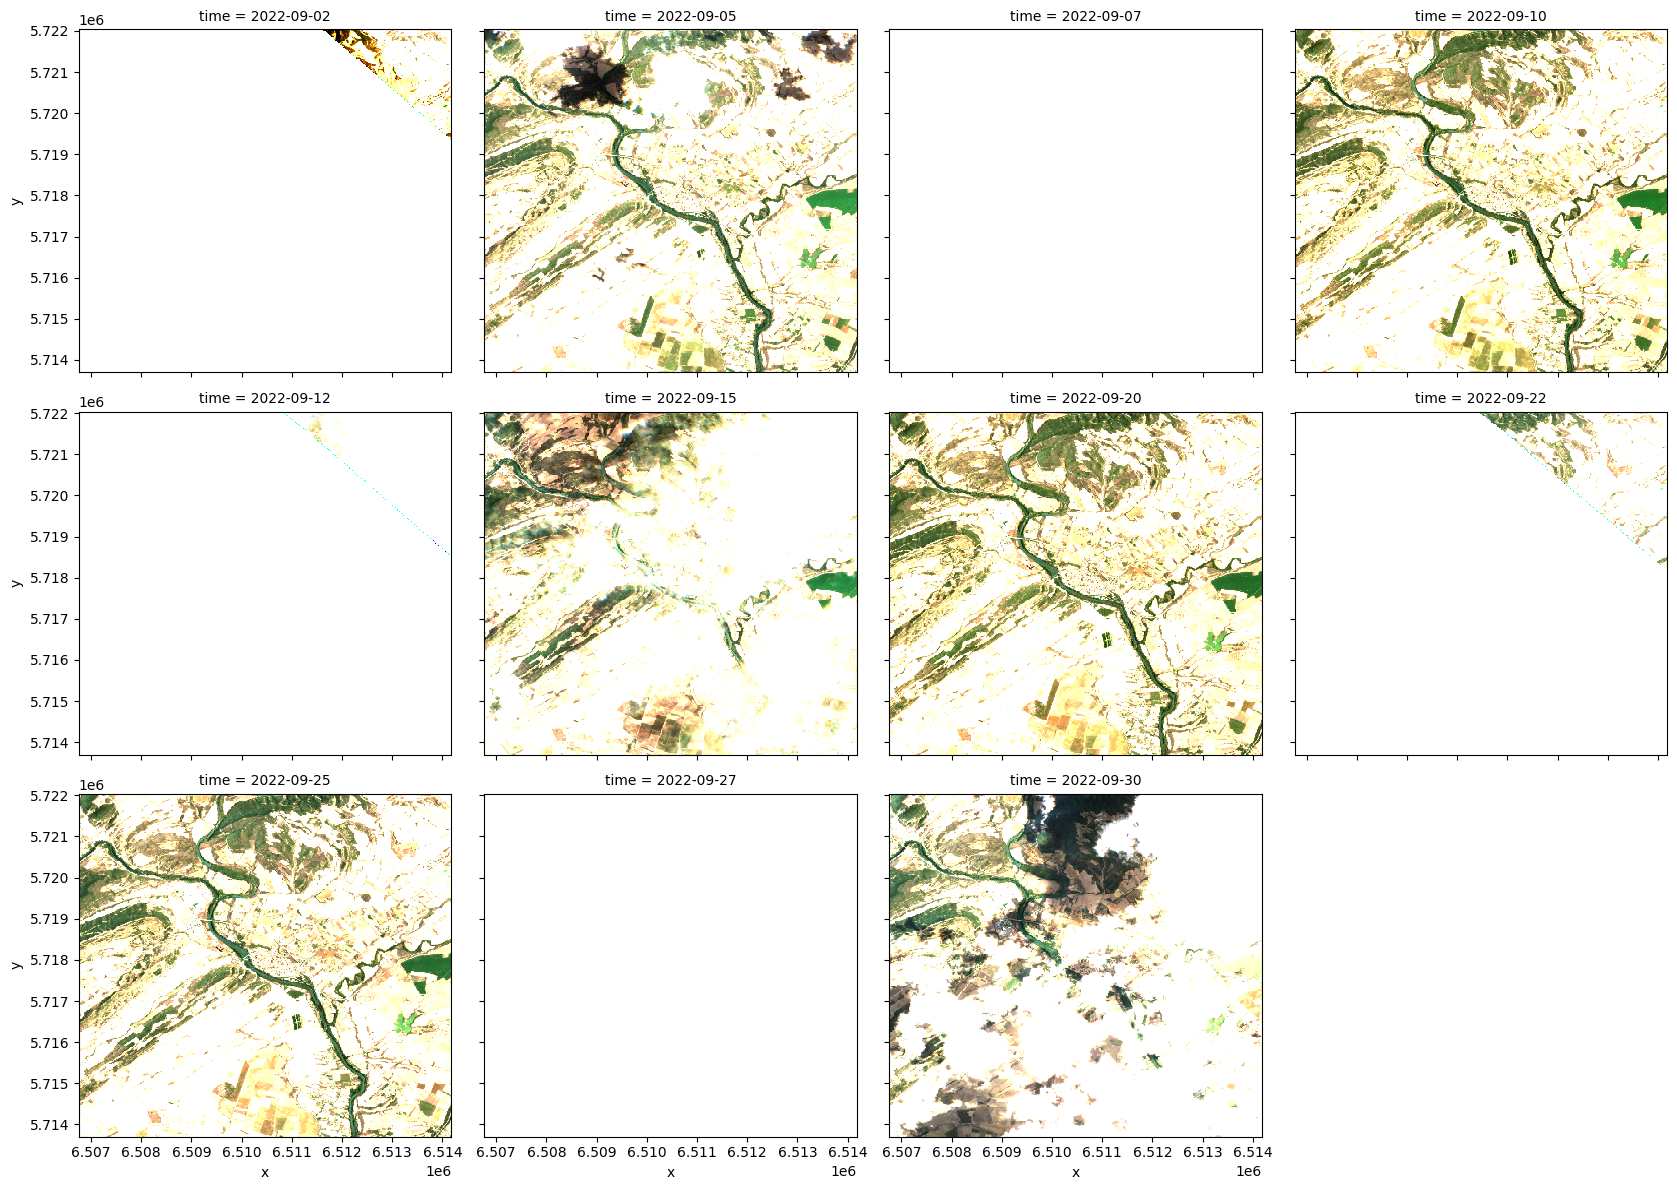

In [22]:
flat_stack.sel(band=["B04", "B03", "B02"]).plot.imshow(
    col="time",
    col_wrap=4,
    rgb="band",
    robust=True,
    size=4,
    vmin=0,
    vmax=1000,
    add_labels=False,
)

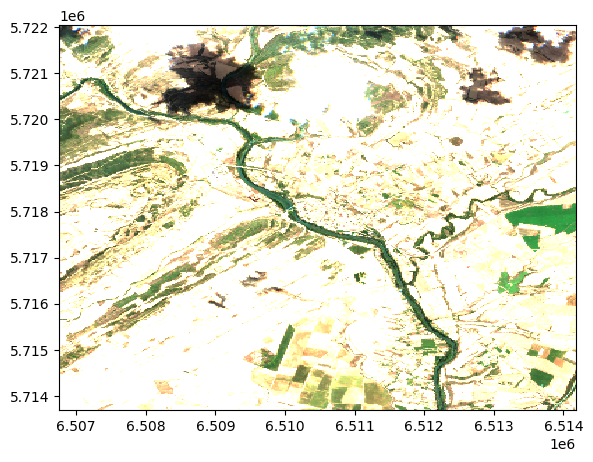

In [23]:
flat_stack.sel(band=["B04", "B03", "B02"], time="2022-09-05").plot.imshow(
    rgb="band",
    robust=True,
    size=5,
    vmin=0,
    vmax=1000,
    add_labels=False,
)

In [24]:
R, G, B, NIR = flat_stack.sel(band=["B04", "B03", "B02", "B08"], time="2022-09-05")

In [25]:
NDVI = R - NIR / R + NIR

In [26]:
NDVI

<xarray.DataArray 'stackstac-8c3b5b0a7ca467e7df19ce7763538f96' (y: 417, x: 371)>
array([[ 833.99280576,  677.89497717,  598.54597701, ..., 6390.75246132,
        5718.7046549 , 4806.61980198],
       [ 731.625     ,  852.54597701,  553.26845638, ..., 6118.64976959,
        5840.68358446, 5444.66666667],
       [ 837.06643357,  747.55228758,  546.16083916, ..., 6337.66777042,
        5048.64239029, 5372.68162209],
       ...,
       [4942.58829268, 4958.57338552, 5490.6489726 , ..., 4084.45261845,
        4011.19886364, 5610.53859649],
       [4766.49842602, 5444.57955556, 5614.66      , ..., 4104.35778636,
        2921.65446224, 4269.80717489],
       [5078.33193277, 4980.62082139, 5436.62946818, ..., 4980.53121903,
        2411.39701493, 3921.12252964]])
Coordinates: (12/25)
    time                          datetime64[ns] 2022-09-05
    id                            <U24 'S2B_30TXN_20220905_0_L2A'
  * x                             (x) float64 6.507e+06 6.507e+06 ... 6.514e+06
  * y                             (y) float64 5.722e+06 5.722e+06 ... 5.714e+06
    sentinel:sequence             <U1 '0'
    instruments                   <U3 'msi'
    ...                            ...
    sentinel:product_id           <U60 'S2B_MSIL2A_20220905T105619_N0400_R094...
    updated                       <U24 '2022-09-05T15:50:57.280Z'
    constellation                 <U10 'sentinel-2'
    proj:shape                    object {10980}
    proj:transform                object {0, 4800000, 600000, 1, 10, -10}
    epsg                          int64 5070

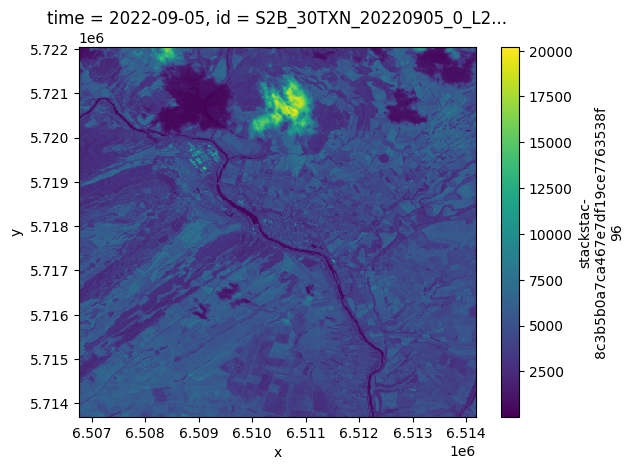

In [27]:
NDVI.plot.imshow(cmap="viridis")

## Using spyndex

In [29]:
import spyndex

In [30]:
# All indices
spyndex.indices

SpectralIndices(['AFRI1600', 'AFRI2100', 'ANDWI', 'ARI', 'ARI2', 'ARVI', 'ATSAVI', 'AVI', 'AWEInsh', 'AWEIsh', 'BAI', 'BAIM', 'BAIS2', 'BCC', 'BI', 'BITM', 'BIXS', 'BLFEI', 'BNDVI', 'BRBA', 'BWDRVI', 'BaI', 'CCI', 'CIG', 'CIRE', 'CSI', 'CSIT', 'CVI', 'DBI', 'DBSI', 'DPDD', 'DSI', 'DSWI1', 'DSWI2', 'DSWI3', 'DSWI4', 'DSWI5', 'DVI', 'DVIplus', 'DpRVIHH', 'DpRVIVV', 'EBBI', 'EMBI', 'EVI', 'EVI2', 'ExG', 'ExGR', 'ExR', 'FCVI', 'GARI', 'GBNDVI', 'GCC', 'GDVI', 'GEMI', 'GLI', 'GM1', 'GM2', 'GNDVI', 'GOSAVI', 'GRNDVI', 'GRVI', 'GSAVI', 'GVMI', 'IAVI', 'IBI', 'IKAW', 'IPVI', 'IRECI', 'LSWI', 'MBI', 'MBWI', 'MCARI', 'MCARI1', 'MCARI2', 'MCARI705', 'MCARIOSAVI', 'MCARIOSAVI705', 'MGRVI', 'MIRBI', 'MLSWI26', 'MLSWI27', 'MNDVI', 'MNDWI', 'MNLI', 'MRBVI', 'MSAVI', 'MSI', 'MSR', 'MSR705', 'MTCI', 'MTVI1', 'MTVI2', 'MuWIR', 'NBAI', 'NBLI', 'NBLIOLI', 'NBR', 'NBR2', 'NBRSWIR', 'NBRT1', 'NBRT2', 'NBRT3', 'NBRplus', 'NBSIMS', 'NBUI', 'ND705', 'NDBI', 'NDBaI', 'NDCI', 'NDDI', 'NDGI', 'NDGlaI', 'NDII', 'N

In [31]:
# NDVI index
spyndex.indices["NDVI"]

SpectralIndex(NDVI: Normalized Difference Vegetation Index)
        * Application Domain: vegetation
        * Bands/Parameters: ['N', 'R']
        * Formula: (N-R)/(N+R)
        * Reference: https://ntrs.nasa.gov/citations/19740022614
        

In [32]:
# Formula of the NDVI
spyndex.indices["NDVI"].formula

'(N-R)/(N+R)'

In [33]:
spyndex.indices["SAVI"].formula

'(1.0+L)*(N-R)/(N+R+L)'

In [34]:
# Blue band
spyndex.bands

Bands(['A', 'B', 'G', 'G1', 'N', 'N2', 'R', 'RE1', 'RE2', 'RE3', 'S1', 'S2', 'T', 'T1', 'T2', 'WV', 'Y'])

In [35]:
# Blue band
spyndex.bands['R']

Band(R: Red)
        

In [59]:
import spyndex
import xarray as xr
import matplotlib.pyplot as plt
from rasterio import plot
import rasterio
import rioxarray


In [46]:
# Compute the desired spectral indices

idx = spyndex.computeIndex(
    index = ["NDVI","GNDVI","SAVI"],
    params = {
        "N": NIR,
        "R": R,
        "G": G,
        "L": 0.5
    }
)




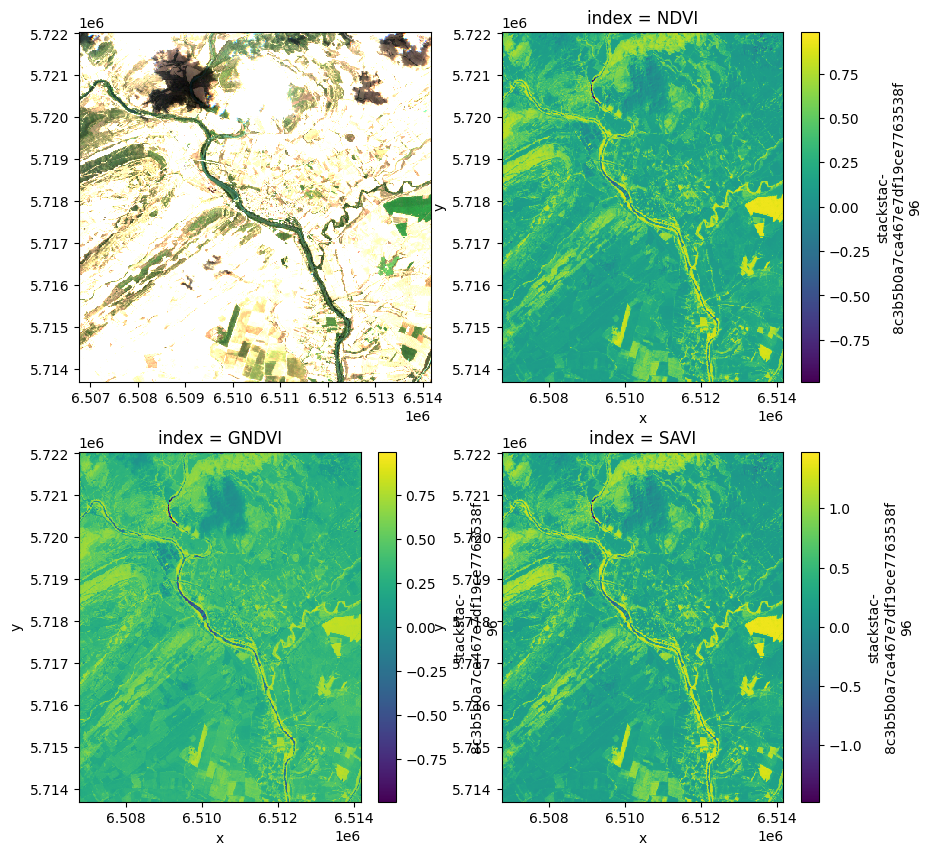

In [55]:
# Plot the indices (and the RGB image for comparison)
fig, ax = plt.subplots(2,2,figsize = (10,10))
flat_stack.sel(band=["B04", "B03", "B02"], time="2022-09-05").plot.imshow(
    rgb="band",
    robust=True,
    vmin=0,
    vmax=1000,
    add_labels=False,
    ax = ax[0,0]
)
idx.sel(index = "NDVI").plot.imshow(cmap='viridis',ax = ax[0,1], origin='upper')
idx.sel(index = "GNDVI").plot.imshow(cmap='viridis',ax = ax[1,0], origin='upper')
idx.sel(index = "SAVI").plot.imshow(cmap='viridis',ax = ax[1,1], origin='upper')

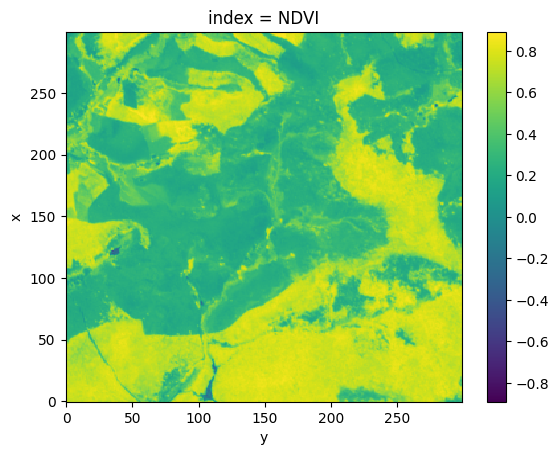

In [39]:
idx.sel(index = "NDVI").plot.imshow(cmap='viridis')

In [ ]:
def write_dataarray_to_geotiff(data_array, filename):
    # Extract the metadata from the DataArray
    meta = {
        'count': 1,  # Number of bands (assuming a single band)
        'crs': data_array.rio.crs,  # CRS from the DataArray
        'transform': data_array.rio.transform(),  # Transform from the DataArray
        'dtype': str(data_array.dtype),  # Data type
        'nodata': None,  # NoData value (optional, set to None if not needed)
    }

    # Write the DataArray to a GeoTIFF file
    with rasterio.open(filename, 'w', **meta) as dst:
        dst.write(data_array.values, 1)  # Write the data to the first band

# Assuming you have a DataArray called 'my_data_array'
write_dataarray_to_geotiff(my_data_array, 'output.tif')


In [57]:
NDVI = idx.sel(index = "NDVI")

In [60]:
NDVI.rio.to_raster('ndvi_test.tiff')